In [1]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import tensorflow as tf
from baselines.ppo1 import mlp_policy, cnn_policy_carving, \
    cnn_policy_carving_two_maps, cnn_policy_carving_explicit_target
import baselines.common.tf_util as U
import gym
%matplotlib inline

In [2]:
traj_data = joblib.load("data/trajs/simple_particle_traj.pkl")
observations = traj_data["observations"]
observations = np.array(observations)
actions = traj_data["actions"]
actions = np.array(actions)

print("Observation Shape: ",observations.shape)
print("Action Shape: ", actions.shape)

#print("Split observations into separate scenes")


Observation Shape:  (1000, 2063)
Action Shape:  (1000, 4)


# Plot the density-template differences

In [3]:
def plot_at_frame(frame):
    obs_at_frame = observations[frame]
    curr_particle_density_diff = obs_at_frame[15:15+32*32]
    curr_particle_density_diff = np.reshape(curr_particle_density_diff,(32,32))
    prev_particle_density_diff = obs_at_frame[15+32*32::]
    prev_particle_density_diff = np.reshape(prev_particle_density_diff,(32,32))
#     print(curr_particle_density_diff.shape)
#     print(prev_particle_density_diff.shape)
    fig, axes = plt.subplots(1,3,figsize=(20,20))

    img1 = axes[0].imshow(curr_particle_density_diff)
    img2 = axes[1].imshow(prev_particle_density_diff)
    img3 = axes[2].imshow(curr_particle_density_diff-prev_particle_density_diff)
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85,0.4,0.03,0.2])
    fig.colorbar(img3,cax=cbar_ax)
#     print("asf")
#     cax = plt.axis([0.95,0.05,0.01,0.3])
#     fig.colorbar(img1,ax=axes[0],cax = cax)
#     fig.colorbar(img2,ax=axes[1])
#     fig.colorbar(img3,ax=axes[2])
#     fig.tight_layout()

def plot_hidden_layer_activation(activation):
    fig, axes = plt.subplots(2,4,figsize=(10,10))
    for i in range(2):
        for j in range(4):
            axes[i,j].imshow(activation[0][0,:,:,i*4+j])
            
    fig.tight_layout()

In [4]:
w = widgets.IntSlider(min=0,max=999)

# plot_at_frame(0,fig,axes)
interact(plot_at_frame, frame = w)


interactive(children=(IntSlider(value=0, description='frame', max=999), Output()), _dom_classes=('widget-inter…

<function __main__.plot_at_frame(frame)>

In [5]:
def restore_policy(sess, policy, policy_params):
    cur_scope = policy.get_variables()[0].name[0:policy.get_variables()[0].name.find('/')]
    orig_scope = list(policy_params.keys())[0][0:list(policy_params.keys())[0].find('/')]

    for i in range(len(policy.get_variables())):
        assign_op = policy.get_variables()[i].assign(
            policy_params[policy.get_variables()[i].name.replace(cur_scope, orig_scope, 1)])
        sess.run(assign_op)

def cnn_explicity_target_policy_fn(name, ob_space, ac_space):  # pylint: disable=W0613
    return cnn_policy_carving_explicit_target.CnnPolicyCarvingExplicitTarget(name=name, ob_space=ob_space,
                                                                             ac_space=ac_space
                                                                             )


In [6]:
policy_filename = "data/2019-05-16_10:31:10_SimplerParticleCarving-v2_seed_0/ppo_SimplerParticleCarving-v2_run_0/policy/"
policy_filename +="policy_params_235.pkl"
print(policy_filename)
env = gym.make("SimplerParticleCarving-v2")
policy_param =joblib.load(policy_filename)

tf.reset_default_graph()
activation1 = None
activation2 = None
with U.single_threaded_session() as sess:
    pi = cnn_explicity_target_policy_fn('pi', env.observation_space, env.action_space)
    restore_policy(sess, pi, policy_param)

    tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='pi/pol/conv_1')
    obs_at_frame = observations[36]
    # curr_particle_density_diff = obs_at_frame[15:15+32*32]
    # curr_particle_density_diff = np.reshape(curr_particle_density_diff,(32,32))
    # prev_particle_density_diff = obs_at_frame[15+32*32::]
    # prev_particle_density_diff = np.reshape(prev_particle_density_diff,(32,32))
    # conv_obs = np.concatenate([curr_particle_density_diff,prev_particle_density_diff],axis=-1)
    activation1 = pi.getPolActivation(obs_at_frame,1)
    activation2 = pi.getPolActivation(obs_at_frame,2)
#     print(activation)

[2019-10-31 14:00:42,863] Making new env: SimplerParticleCarving-v2


data/2019-05-16_10:31:10_SimplerParticleCarving-v2_seed_0/ppo_SimplerParticleCarving-v2_run_0/policy/policy_params_235.pkl


/home/yzhang/MyDartEnv/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


[2019-10-31 14:00:43,173] From /home/yzhang/anaconda3/envs/deformableManip/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Conv_1 shape:  (?, 13, 13, 8)
Conv_2 shape:  (?, 5, 5, 8)
Conv_2 Flattened shape:  (?, 200)
Instructions for updating:
Use keras.layers.dense instead.


[2019-10-31 14:00:43,200] From /home/yzhang/MyBaselines/baselines/ppo1/cnn_policy_carving_explicit_target.py:56: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


(?, 264)
Conv_1 shape:  (?, 13, 13, 8)
Conv_2 shape:  (?, 5, 5, 8)
Conv_2 Flattened shape:  (?, 200)


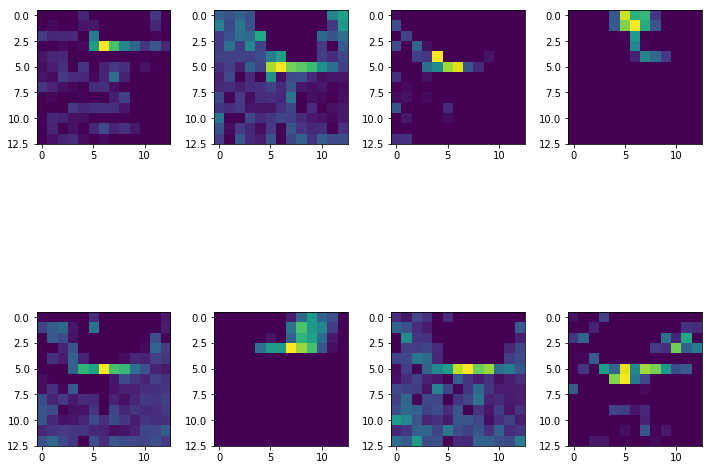

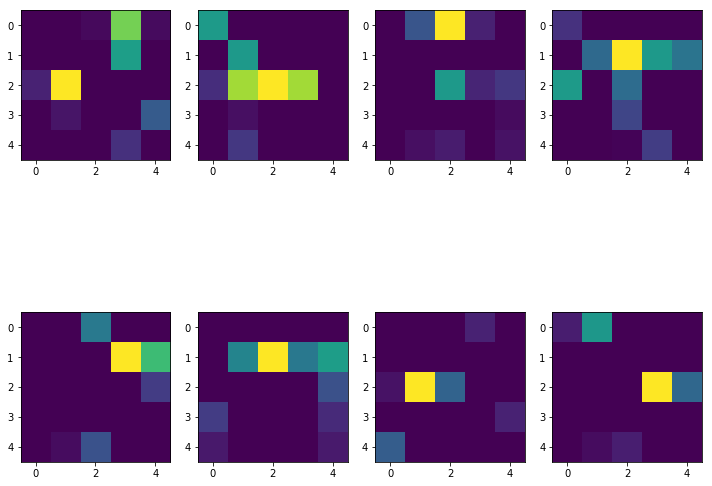

In [7]:
plot_hidden_layer_activation(activation1)
plot_hidden_layer_activation(activation2)